In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
# from tf.transformations import euler_from_quaternion
import sys
sys.path.append("/home/ksavevska/talos_ws/dmpbbo/")

from dmpbbo.dmps.Trajectory import Trajectory
import quaternion
from dtaidistance import dtw

In [19]:
# TODO: refactor this!

def q_dist(q1, q2):
    prod = q1*q2.conj()
    prod = prod/np.linalg.norm(quaternion.as_float_array(prod))
    # log = np.arccos(prod.real)*(prod.imag/np.linalg.norm(prod.imag))
    log = np.log(prod).imag
    return 2*np.linalg.norm(log)

def calculate_dist_to_cop(cost_vars):                        
    n_misc = 15                                                                                         
    cop_x = cost_vars[:,-n_misc]                                  
    cop_y = cost_vars[:,-n_misc+1]                                   

    rf_y = cost_vars[0, -2]                                                            
    lf_y = cost_vars[0, -5]                       
    rf_x = cost_vars[0, -3]
    lf_x = cost_vars[0, -6]             
    ref_cop = np.array([(rf_x + lf_x)/2, (rf_y + lf_y)/2])
    dist_to_cop = np.sum(np.sqrt((cop_x - ref_cop[0])**2 + (cop_y - ref_cop[1])**2))/len(cop_x)
    return dist_to_cop

def calculate_costs(cost_vars, traj_demonstrated_):
    n_dims = 18
    n_misc = 15
    n_time_steps = cost_vars.shape[0]
    
    ee_pos_goal_ = [0.65, -0.4, 0.0] 
    
    joint_states = cost_vars[:,:n_dims]
    vel = cost_vars[:,n_dims:2*n_dims]
    acc = cost_vars[:,2*n_dims:3*n_dims]
    cop_x = cost_vars[:,-n_misc]
    cop_y = cost_vars[:,-n_misc+1]

    ee_pos_x = cost_vars[:,-n_misc+2]
    ee_pos_y = cost_vars[:,-n_misc+3]
    ee_pos_z = cost_vars[:,-n_misc+4]

    ee_rot_x = cost_vars[:,-n_misc+5]
    ee_rot_y = cost_vars[:,-n_misc+6]
    ee_rot_z = cost_vars[:,-n_misc+7]
    ee_rot_w = cost_vars[:,-n_misc+8]
    
    x_size = 0.21
    y_size = 0.13
    sp_y_1 = cv[0, -2] - y_size/2
    sp_y_2 = cv[0, -5] + y_size/2
    sp_x_1 = max(cv[0, -6] - x_size/2, cv[0, -3] - x_size/2)
    sp_x_2 = min(cv[0, -6] + x_size/2, cv[0, -3] + x_size/2)
    
    stability_cost = [0]*len(cop_x)
    for i in range(len(cop_x)):
        if cop_x[i] > sp_x_1 and cop_x[i] < sp_x_2 and cop_y[i] > sp_y_1 and cop_y[i] < sp_y_2:
            if min(abs(sp_x_1-cop_x[i]), abs(sp_x_2-cop_x[i]), abs(sp_y_1-cop_y[i]), abs(sp_y_2-cop_y[i])) > 0.0095:
                stability_cost[i] = (min(x_size/2, (sp_y_2-sp_y_1)/2) / (min(abs(sp_x_1-cop_x[i]), abs(sp_x_2-cop_x[i]), abs(sp_y_1-cop_y[i]), abs(sp_y_2-cop_y[i]))) - 1)**2
            else:
                stability_cost[i] = 100
        else:
            stability_cost[i] = 100
    # Normalize the stability cost
    stability_cost = np.array(stability_cost)/100
    
    dist_to_goal = (np.sqrt((ee_pos_x[-1] - ee_pos_goal_[0])**2 + (ee_pos_y[-1]-ee_pos_goal_[1])**2 + (ee_pos_z[-1]-ee_pos_goal_[2])**2))
  
    q_desired = quaternion.from_float_array([0.5, 0.5, -0.5, -0.5])
    q_goal = quaternion.from_float_array([ee_rot_w[-1], ee_rot_x[-1], ee_rot_y[-1], ee_rot_z[-1]])
    orientation_cost = q_dist(q_desired, q_goal)    
#     orientation_cost = np.sum(np.sqrt((goal_euler[0]-desired_goal_euler[0])**2+(goal_euler[1]-desired_goal_euler[1])**2+(goal_euler[2]-desired_goal_euler[2])**2)
#     orientation_cost = np.linalg.norm(np.array(goal_euler) - np.array(desired_goal_euler))
#     q_desired_goal = quaternion.from_float_array([0.5, 0.5, -0.5, -0.5])
#     q_goal = quaternion.from_float_array([ee_rot_w[-1], ee_rot_x[-1], ee_rot_y[-1], ee_rot_z[-1]])
#     q_diff = q_goal * q_desired_goal.inverse()
#     q_diff = quaternion.from_float_array(quaternion.as_float_array(q_diff) / np.linalg.norm(quaternion.as_float_array(q_diff)))
#     orientation_cost = np.sum(np.abs(quaternion.as_rotation_vector(q_diff)[:2]))
    
    acc_sums = np.array([np.sum(acc[:,a]**2)/len(acc[:,a]) for a in range(acc.shape[1])])
    acc_cost = np.sum(acc_sums)/len(acc_sums)

    vel_cost = np.sum(np.square(vel[-1]))/vel.shape[1]

    traj_cost = np.sum([dtw.distance(joint_states[:,i], traj_demonstrated_.ys[:, i]) for i in range(joint_states.shape[1])]) / joint_states.shape[1]

    dist_to_cop = calculate_dist_to_cop(cost_vars)
    
    return np.sum(stability_cost)/len(stability_cost), dist_to_goal, orientation_cost, acc_cost, vel_cost, traj_cost, dist_to_cop

In [31]:
# TODO: refactor this!
results_path = "results_short_traj_upper_body_goal_dtw_25_lr05/"
updates = np.sort([update for update in os.listdir(results_path) if "update0" in update])
stab_cost = []
goal_cost = []
orientation_cost = []
acceleration_cost = []
velocity_cost = []
trajectory_cost = []
dist_to_cop = []

for update in updates:
    path = results_path + update + "/"
    files = np.sort([file for file in os.listdir(path) if "eval_cost_vars" in file])
    trajectory = Trajectory.loadtxt("trajectories/trajectory.txt")

    for f in files:
        cv = np.loadtxt(path+f)
        if not (cv[-1,:] == 100).any():
            
            s, g, o, a, v, t, d = calculate_costs(cv, trajectory)
            stab_cost.append(s)
            goal_cost.append(g)
            orientation_cost.append(o)
            acceleration_cost.append(a)
            velocity_cost.append(v)
            trajectory_cost.append(t)
            dist_to_cop.append(d)
            
        
df = pd.DataFrame(columns=["stab_cost", "goal_cost", "orient_cost", "traj_cost", "acc_cost", "vel_cost", "dist_to_cop"])

df["stab_cost"] = stab_cost
df["goal_cost"] = goal_cost
df["orient_cost"] = orientation_cost
df["traj_cost"] = trajectory_cost
df["acc_cost"] = acceleration_cost
df["vel_cost"] = velocity_cost
df["dist_to_cop"] = dist_to_cop


df.describe()

,stab_cost,goal_cost,orient_cost,traj_cost,acc_cost,vel_cost,dist_to_cop
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.080102,0.019695,0.078039,1.879064,0.027414,0.086738,0.048980
std,0.110011,0.016515,0.098557,0.309524,0.016029,0.068017,0.012230
min,0.002999,0.002419,0.008969,0.071806,0.000979,0.037597,0.027714
25%,0.008378,0.011310,0.043738,1.795142,0.016754,0.053660,0.038954
50%,0.034213,0.017028,0.058711,1.909058,0.026529,0.061205,0.049698
75%,0.114552,0.022197,0.079288,2.019532,0.035500,0.088457,0.056279
max,0.611826,0.160141,0.782249,2.640847,0.077732,0.498965,0.084979


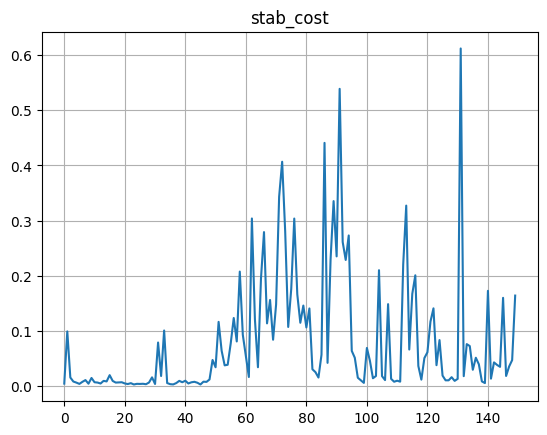

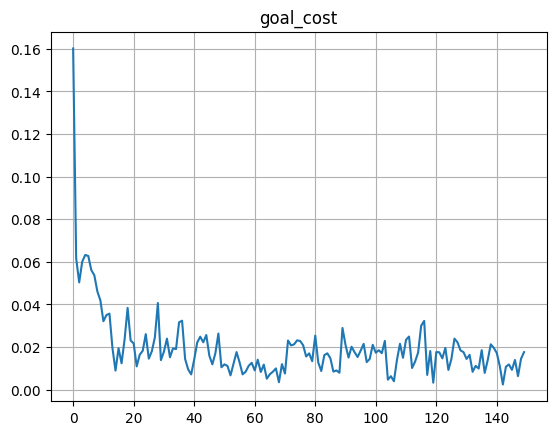

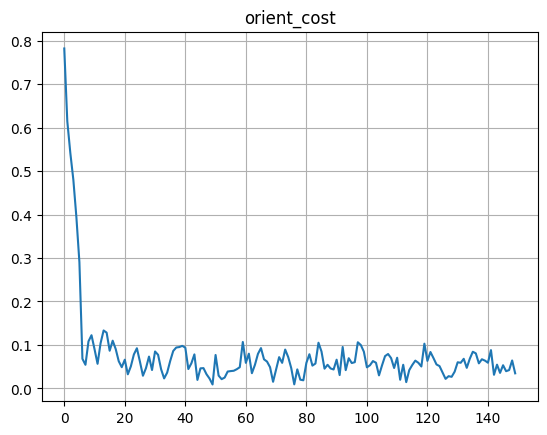

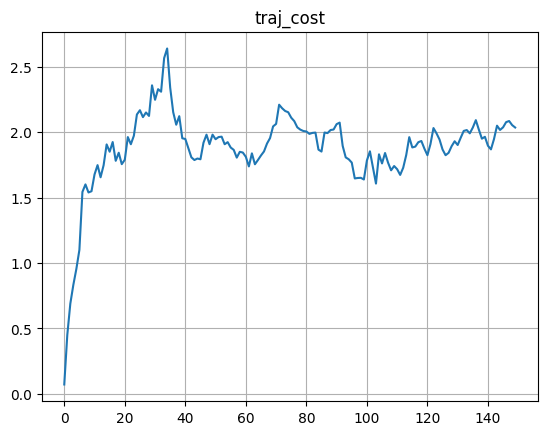

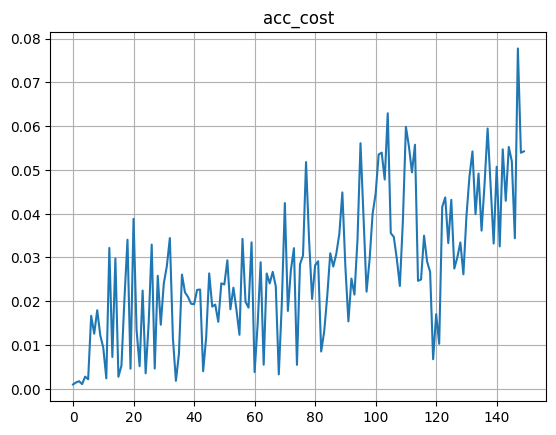

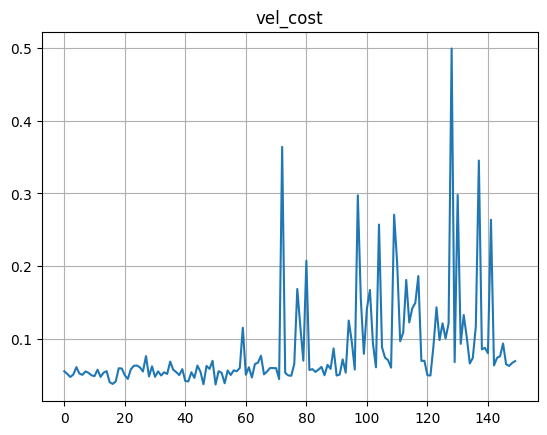

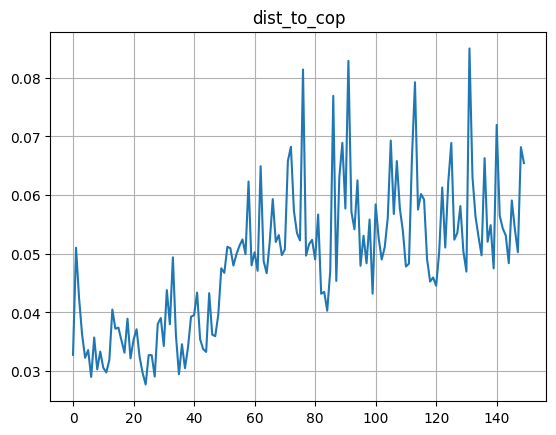

In [32]:
for col in df.columns:
    plt.plot(df[col])
    plt.grid()
    plt.title(col)
    plt.show()

In [33]:
cv0 = np.loadtxt(results_path+"/update00000/eval_cost_vars.txt")
cvT = np.loadtxt(results_path+"/update00149/eval_cost_vars.txt")


n_misc=15
cop_0 = cv0[:,-n_misc:-n_misc+2]
cop_T = cvT[:,-n_misc:-n_misc+2]

In [34]:
rf_y = cv0[0, -2]                                                            
lf_y = cv0[0, -5]                       
rf_x = cv0[0, -3]
lf_x = cv0[0, -6]             
ref_cop = np.array([(rf_x + lf_x)/2, (rf_y + lf_y)/2])
dist_to_cop = np.sum((1/len(cop_0[:,0]))*np.sqrt((cop_0[:,0] - ref_cop[0])**2 + (cop_0[:,1] - ref_cop[1])**2))

In [35]:
dist_to_cop

0.032765310805992945

In [36]:
dist_to_cop2 = np.sum(np.sqrt((cop_0[:,0] - ref_cop[0])**2 + (cop_0[:,1] - ref_cop[1])**2))/len(cop_0[:,0])

In [37]:
dist_to_cop2

0.03276531080599294

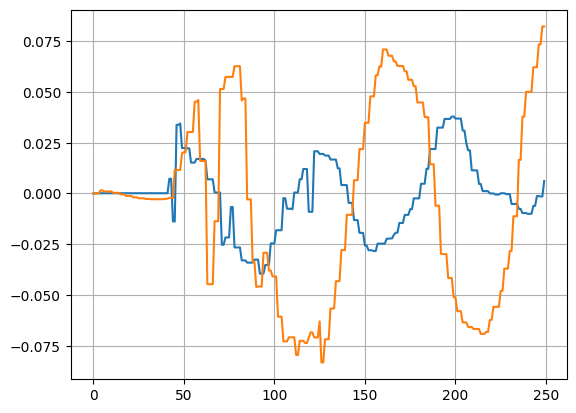

In [39]:
plt.plot(cop_0[:,1])
plt.plot(cop_T[:,1])
plt.grid()
plt.show()

In [63]:
(1/6)/df.mean()

stab_cost      14.937723
goal_cost      10.886533
orient_cost     0.250917
traj_cost       0.802190
acc_cost       26.517803
vel_cost        3.922722
dtype: float64

<Axes: >

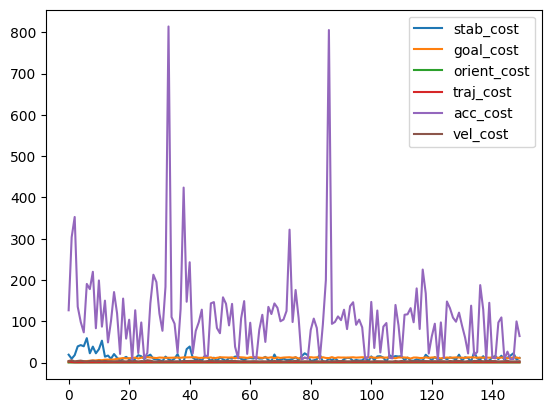

In [32]:
((1/6)/df).plot()

8.839094551732094
17.614960816076824


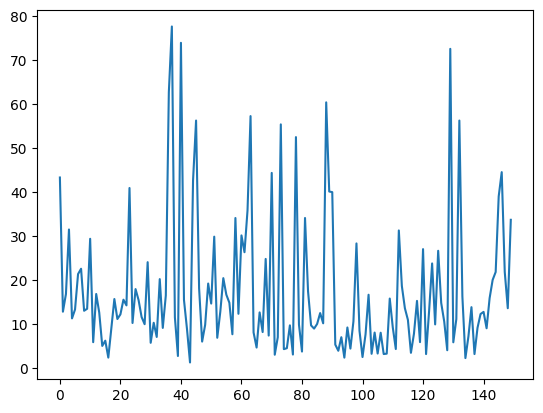

In [4]:
col = "stab_cost"
print(0.3/df[col].mean())
print((0.3/df[col]).mean())
plt.plot((0.3/df[col]))

12.884639678181262
14.091803623461377


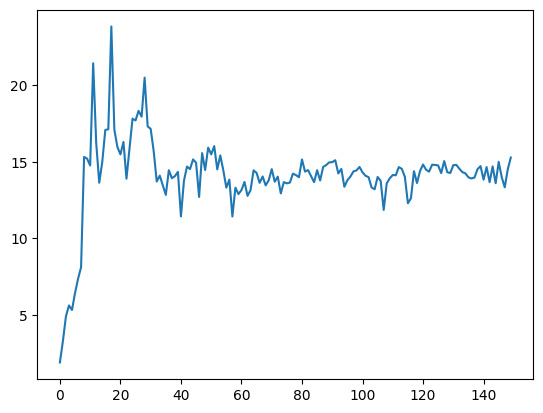

In [5]:
col = "goal_cost"
print(0.3/df[col].mean())
print((0.3/df[col]).mean())
plt.plot((0.3/df[col]))

0.5828482563736177
0.5851506681570366


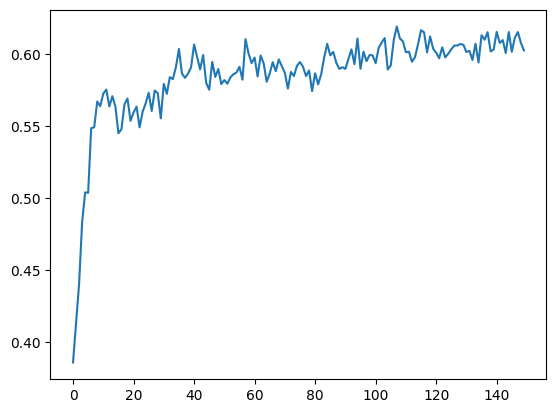

In [6]:
col = "orient_cost"
print(0.3/df[col].mean())
print((0.3/df[col]).mean())
plt.plot((0.3/df[col]))

4.707266284132766
4.803641633212675


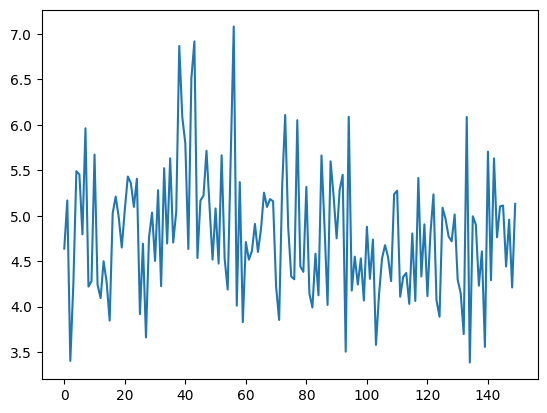

In [67]:
col = "vel_cost"
print(0.2/df[col].mean())
print((0.2/df[col]).mean())
plt.plot((0.2/df[col]))

15.910682069445615
76.92685513589274


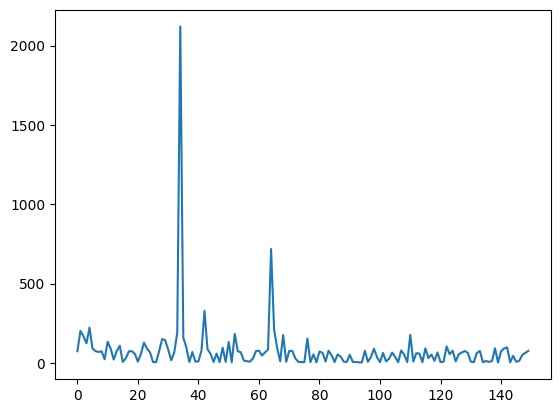

In [68]:
col = "acc_cost"
print(0.1/df[col].mean())
print((0.1/df[col]).mean())
plt.plot((0.1/df[col]))

0.481313808412428
0.4868410189547204


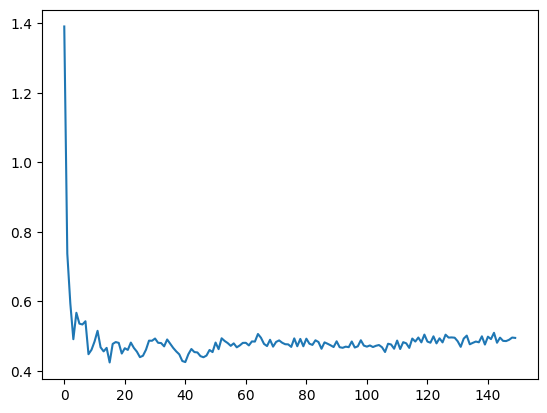

In [69]:
col = "traj_cost"
print(0.1/df[col].mean())
print((0.1/df[col]).mean())
plt.plot((0.1/df[col]))

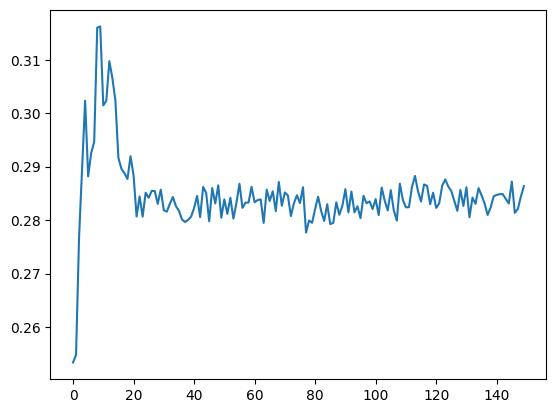

In [41]:
plt.plot((0.2/df[col]))


In [2]:
cv = np.loadtxt("results_learning_wb_goal_covar_adapt_initial_traj_3_tau/updates_rarm/update00149/eval_cost_vars.txt")
n_misc = 15
ee_rot_x = cv[:,-n_misc+5]
ee_rot_y = cv[:,-n_misc+6]
ee_rot_z = cv[:,-n_misc+7]
ee_rot_w = cv[:,-n_misc+8]

In [5]:
desired_goal_euler = euler_from_quaternion(quaternion=[0.5, -0.5, -0.5, 0.5], axes='rxyz')
goal_euler = euler_from_quaternion(quaternion=[ee_rot_x[-1], ee_rot_y[-1], ee_rot_z[-1], ee_rot_w[-1]], axes='rxyz')
    
orientation_cost = np.sum(np.sqrt((goal_euler[0]-desired_goal_euler[0])**2+(goal_euler[1]-desired_goal_euler[1])**2+(goal_euler[2]-desired_goal_euler[2])**2))


In [34]:
stab_cost = []
goal_cost = []
orientation_cost = []
acceleration_cost = []

path = "results_learning_wb_goal_covar_adapt_initial_traj_6_dtw/updates_rarm/"
updates = np.sort(os.listdir(path))
for update in updates:
    if "update0" in update:
        cv = np.loadtxt(path+update+"/eval_cost_vars.txt")
        s, g, o, a = calculate_costs(cv)
        stab_cost.append(s)
        goal_cost.append(g)
        orientation_cost.append(o)
        acceleration_cost.append(a)

OSError: results_learning_wb_goal_covar_adapt_initial_traj_6_dtw/updates_rarm/update00150/eval_cost_vars.txt not found.

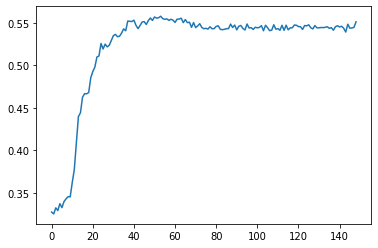

In [38]:
plt.plot(np.array(orientation_cost)[1:]*0.3)

In [ ]:
           
    
# roll = pi/2
# pitch = 0
# yaw = -pi/2           
# goal_orientation = (np.sqrt((ee_rpy_x[-1] - roll)**2 + (ee_rpy_y[-1]-pitch)**2 + (ee_rpy_z[-1] - yaw)**2))